In [1]:
import os 

os.chdir('E://bond-dex/bond-amm-research/')

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

In [3]:
class Rate(): 
    
    def __init__(self, T, N, r0, a, b, sigma, random_seed=0, N_simulated=None): 
        self.T = T
        self.N = N 
        self.r0 = r0 
        self.a = a 
        self.b = b 
        self.sigma = sigma 
        self.dt = T / N
        self.random_seed = random_seed
        np.random.seed(self.random_seed)
        
        if N_simulated is None: 
            self.Ns = N 
        else: 
            self.Ns = N_simulated
        
    def cir(self): 
        
        out = np.zeros(self.Ns)
        
        out[0] = r0 
        
        for i in range(self.Ns - 1):
            dr_i = self.a * (self.b - out[i]) * self.dt + \
                    self.sigma * np.sqrt(out[i]) * np.random.normal() * np.sqrt(self.dt)
            out[i + 1] = out[i] + dr_i
        
        return out

In [4]:
T = 10
YEAR_LENGTH = 365*24*60
N = int(T * YEAR_LENGTH)

sigma=0.5
a=5
b=0.05

r0 = 0.05

y0 = 0.5

In [5]:
x0 = y0*np.exp(r0)

In [6]:
rate = Rate(T=T, N=N, r0=r0, a=a, b=b, sigma=sigma, random_seed=0, N_simulated=1*YEAR_LENGTH)

r = rate.cir()

Text(0, 0.5, 'Interest Rate')

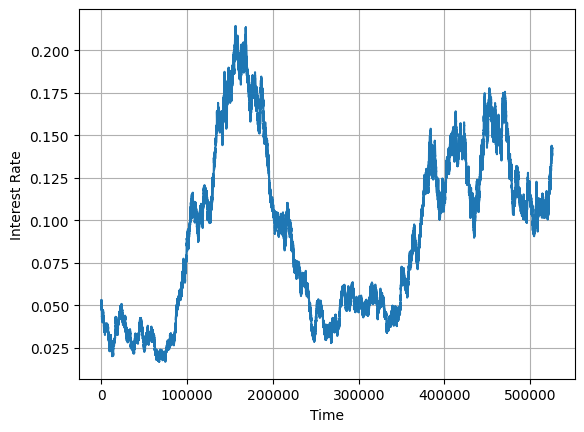

In [7]:
fig, ax = plt.subplots()

ax.plot(r, label='r')

ax.grid()

ax.set_xlabel('Time')
ax.set_ylabel('Interest Rate')

In [8]:
phi = np.exp(r)

In [9]:
dx = np.zeros(phi.shape)
dy = np.zeros(phi.shape)
x = np.zeros(phi.shape)
y = np.zeros(phi.shape)

In [10]:
x[0] = x0
y[0] = y0

In [11]:
for t in range(1, phi.shape[0]):
    dx[t] = (phi[t] * y[t-1] - x[t-1]) / (np.exp(-r[t]*(T - t)/YEAR_LENGTH) + 1)
    dy[t] = -(phi[t] * y[t-1] - x[t-1]) * np.exp(-r[t]*(T - t)/YEAR_LENGTH) / (np.exp(-r[t]*(T - t)/YEAR_LENGTH) + 1)
    x[t] = x[t-1] + dx[t]
    y[t] = y[t-1] + dy[t]

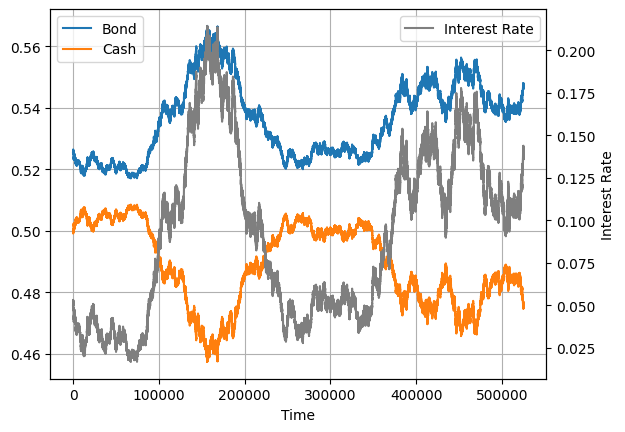

In [22]:
fig, ax = plt.subplots()

ax.plot(x, label='Bond')
ax.plot(y, label='Cash')

ax.grid()

ax.set_xlabel('Time')

ax2 = ax.twinx()

ax2.plot(np.log(x/y), label='Interest Rate', color='tab:grey')
ax2.set_ylabel('Interest Rate')

ax.legend()
ax2.legend()

plt.show()

In [158]:
def sample_trade(dx, dy):
    N = len(dx)
    
    trade_side = np.random.binomial(n=1, p=0.5, size=N)
    
    trade_size = np.where(trade_side == 1, dy, dx)
    
    return trade_side, trade_size

In [159]:
trade_sides, trade_volumes = sample_trade(dx, dy)

### Save simulated trade to csv

In [166]:
trade_df = pd.DataFrame({'dx': dx[1:], 'dy': dy[1:]})
trade_df['action'] = trade_df.dy.apply(lambda x: 'lend' if x > 0 else 'borrow')
trade_df = trade_df.reset_index().rename(columns={'dy': 'cash_volume', 'index': 'timestamp'})[['timestamp', 'action', 'cash_volume']]
trade_df.cash_volume = np.abs(trade_df.cash_volume)
trade_df.timestamp += 1

In [167]:
trade_df.groupby('action').agg({'cash_volume': 'describe'})

cash_volume                                                        \
             count      mean       std           min       25%       50%   
action                                                                     
borrow    263034.0  0.000045  0.000038  2.793109e-10  0.000016  0.000035   
lend      262565.0  0.000045  0.000038  4.501873e-10  0.000016  0.000034   

                            
             75%       max  
action                      
borrow  0.000063  0.000355  
lend    0.000063  0.000398

In [168]:
trade_df.to_csv('data/input/synthetic/synthetic_yield_3.csv', index=False)

In [169]:
trade_df.to_csv('E:/bond-dex/bond-amm-simulation/sources/input/actor_trade/synthetic_yield_3.csv', index=False)

In [170]:
x0, y0

(0.5256355481880121, 0.5)

In [7]:
trade_df = pd.read_csv('data/input/synthetic/synthetic_yield_3.csv')

In [9]:
trade_df.groupby('action').agg({'cash_volume': 'describe'})

cash_volume                                                        \
             count      mean       std           min       25%       50%   
action                                                                     
borrow    263034.0  0.000045  0.000038  2.793109e-10  0.000016  0.000035   
lend      262565.0  0.000045  0.000038  4.501873e-10  0.000016  0.000034   

                            
             75%       max  
action                      
borrow  0.000063  0.000355  
lend    0.000063  0.000398